In [1]:
# https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/07_linear_models/03_preparing_the_model_data.ipynb

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH
START = '2013-01-01'
END = '2017-12-31'
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [4]:
#pip install TA-Lib

### Loading Quandl Wiki Stock Prices & Meta Data
加载数据

In [5]:
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']
DATA_STORE = 'data/assets.h5'
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .assign(volume=lambda x: x.volume.div(1000))
              .swaplevel()
              .sort_index())

    stocks = (store['us_equities/stocks']
              .loc[:, ['marketcap', 'ipoyear', 'sector']])

In [6]:
# 测试：截取prices前n条
# prices = prices.head(10000)


In [7]:
# Remove stocks with few observations

# want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level='ticker').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices = prices.loc[idx[keep, :], :]

In [8]:
prices.tail()

open   close    low   high   volume
ticker date                                            
ZUMZ   2017-12-22  21.55  21.450  21.30  21.70  209.585
       2017-12-26  21.45  21.850  21.45  22.20  213.951
       2017-12-27  21.80  21.150  20.95  22.25  227.325
       2017-12-28  21.20  21.200  21.05  21.45  162.070
       2017-12-29  21.25  20.825  20.80  21.45  222.040

In [9]:
stocks.tail()

,marketcap,ipoyear,sector
ticker,,,
ZOES,1.974000e+08,2014.0,Consumer Services
ZTS,4.165000e+10,2013.0,Health Care
ZTO,1.434000e+10,2016.0,Transportation
ZUO,3.040000e+09,2018.0,Technology
ZYME,4.868100e+08,2017.0,Health Care


In [10]:
stocks.sector.value_counts()

sector
Finance                  1044
Health Care               849
Consumer Services         828
Technology                627
Capital Goods             370
Basic Industries          317
Energy                    312
Public Utilities          277
Consumer Non-Durables     240
Miscellaneous             152
Consumer Durables         149
Transportation            123
Name: count, dtype: int64

### Compute Rolling Average Dollar Volume
计算滚动平均美元交易量

In [11]:
# compute dollar volume to determine universe

# close 是收盘价，volume 是成交量，两者相乘就是当天的总交易金额（即美元交易量）
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)

# 对每只股票（按 ticker 分组），计算过去 21个交易日 的平均美元交易量
# prices['dollar_vol_1m'] = (prices.dollar_vol.groupby('ticker')
#                            .rolling(window=21, level='date')   # pandas < 1.3 
#                            .mean()).values
prices['dollar_vol_1m'] = (prices
                             .groupby(level='ticker')['dollar_vol']
                             .rolling(window=21)
                             .mean()
                             .reset_index(level=0, drop=True)   # 去掉 ticker 层级，保留 date
                            )

# 对每只股票按平均美元交易量进行排名
prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

In [12]:
prices.tail()

open   close    low   high   volume  dollar_vol  \
ticker date                                                           
ZUMZ   2017-12-22  21.55  21.450  21.30  21.70  209.585  4495.59825   
       2017-12-26  21.45  21.850  21.45  22.20  213.951  4674.82935   
       2017-12-27  21.80  21.150  20.95  22.25  227.325  4807.92375   
       2017-12-28  21.20  21.200  21.05  21.45  162.070  3435.88400   
       2017-12-29  21.25  20.825  20.80  21.45  222.040  4623.98300   

                   dollar_vol_1m  dollar_vol_rank  
ticker date                                        
ZUMZ   2017-12-22   11930.001226           1344.0  
       2017-12-26   11963.373076           1347.0  
       2017-12-27   11786.938512           1348.0  
       2017-12-28   11290.208650           1355.0  
       2017-12-29   10790.612631           1366.0

### Add some Basic Factors  
添加一些基本因子

RSI (Compute the Relative Strength Index)

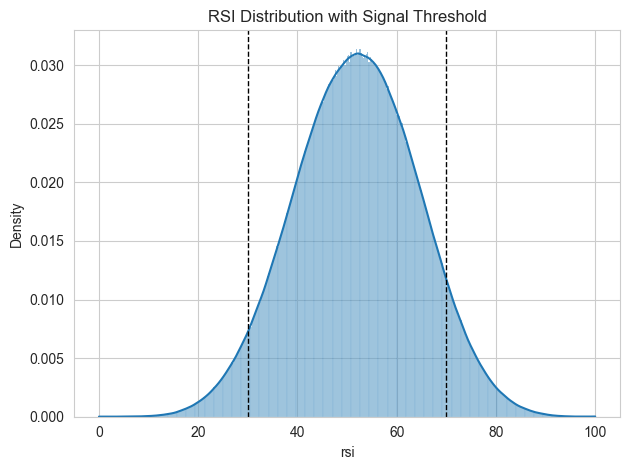

In [13]:
# raw code is bad. 原始代码失效
# prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)
# ax = sns.distplot(prices.rsi.dropna())
prices['rsi'] = prices.groupby(level='ticker').close.transform(RSI)
ax = sns.histplot(prices.rsi.dropna(), kde=True, stat='density')
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

Compute Bollinger Bands

In [14]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

prices = (prices.join(prices
                      #.groupby(level='ticker')  # raw code is bad 原始代码失效
                      .groupby(level='ticker',group_keys=False)
                      .close
                      .apply(compute_bb)))

# np.log1p 既保精度又做压缩
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

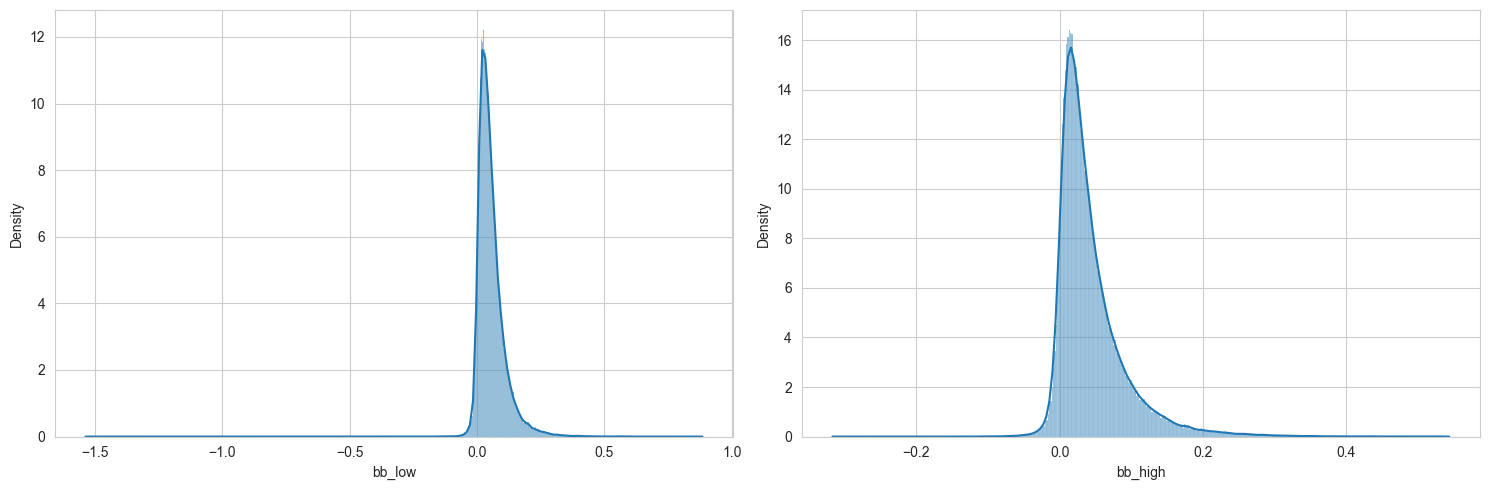

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
# sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
# sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
sns.histplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0], kde=True, stat='density')
sns.histplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1], kde=True, stat='density')
plt.tight_layout();

Compute Average True Range

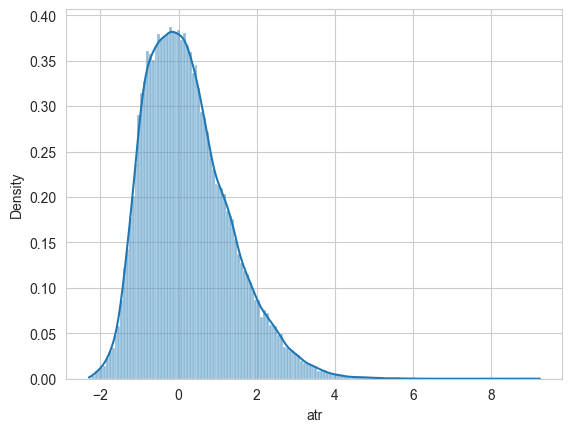

In [16]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

sns.histplot(prices[prices.dollar_vol_rank<50].atr.dropna(), kde=True, stat='density');

Compute Moving Average Convergence/Divergence

In [17]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

In [18]:
prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    3,465,573.0
mean             0.0
std              1.0
min            -10.5
0.1%            -4.1
1%              -2.6
2%              -2.2
3%              -2.0
4%              -1.8
5%              -1.6
50%              0.0
95%              1.6
96%              1.7
97%              1.9
98%              2.1
99%              2.6
99.9%            4.1
max             14.3
Name: macd, dtype: object

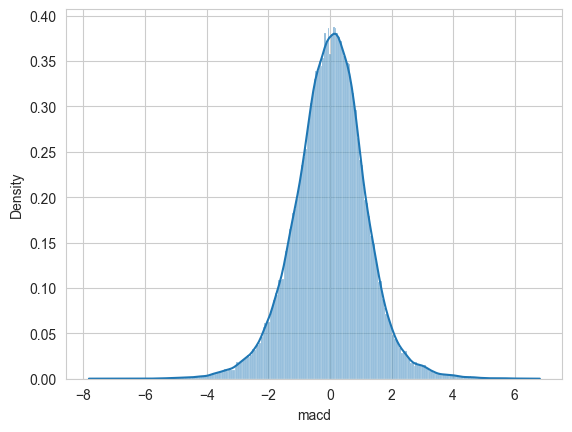

In [19]:
sns.histplot(prices[prices.dollar_vol_rank<100].macd.dropna(), kde=True, stat='density');

In [20]:
prices.tail()

open   close    low   high   volume  dollar_vol  \
ticker date                                                           
ZUMZ   2017-12-22  21.55  21.450  21.30  21.70  209.585  4495.59825   
       2017-12-26  21.45  21.850  21.45  22.20  213.951  4674.82935   
       2017-12-27  21.80  21.150  20.95  22.25  227.325  4807.92375   
       2017-12-28  21.20  21.200  21.05  21.45  162.070  3435.88400   
       2017-12-29  21.25  20.825  20.80  21.45  222.040  4623.98300   

                   dollar_vol_1m  dollar_vol_rank        rsi   bb_high  \
ticker date                                                              
ZUMZ   2017-12-22   11930.001226           1344.0  61.077094  0.028426   
       2017-12-26   11963.373076           1347.0  63.799097  0.010058   
       2017-12-27   11786.938512           1348.0  56.369727  0.040577   
       2017-12-28   11290.208650           1355.0  56.757082  0.039229   
       2017-12-29   10790.612631           1366.0  52.959469  0.050887   

                     bb_low       atr      macd  
ticker date                                      
ZUMZ   2017-12-22  0.086877 -0.419131  0.851425  
       2017-12-26  0.090436 -0.450751  0.889373  
       2017-12-27  0.057586 -0.282948  0.832724  
       2017-12-28  0.059005 -0.449763  0.784419  
       2017-12-29  0.042288 -0.515043  0.696842

Compute Lagged Returns

In [21]:
lags = [1, 5, 10, 21, 42, 63]
returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,23.77%
min,-99.36%
0.01%,-36.97%
0.1%,-16.14%
1%,-6.81%
50%,0.03%
99%,7.27%
99.9%,18.79%
99.99%,46.72%
max,"28,300.00%"


Winsorize outliers

In [22]:
# Winsorize outliers  Winsorize 异常值
q = 0.0001
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

# Shift lagged returns  移位滞后回报
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

# Compute Forward Returns  计算前向回报
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

# Combine Price and Meta Data 结合价格和元数据
prices = prices.join(stocks[['sector']])

# Create time and sector dummy variables  创建时间和板块 临时变量
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month
prices.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3566454 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 46 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             3566119 non-null  float64
 1   close            3566454 non-null  float64
 2   low              3566438 non-null  float64
 3   high             3566438 non-null  float64
 4   volume           3566454 non-null  float64
 5   dollar_vol       3566454 non-null  float64
 6   dollar_vol_1m    3505314 non-null  float64
 7   dollar_vol_rank  3505314 non-null  float64
 8   rsi              3523656 non-null  float64
 9   bb_high          3508365 non-null  float64
 10  bb_low           3508308 non-null  float64
 11  atr              3523561 non-null  float64
 12  macd             3465573 non-null  float64
 13  return_1d        3563397 non-null  float64
 14  return_5d        3551169 non-null  float6

In [ ]:
prices['sector'] = prices['sector'].str.lower().str.replace(' ', '_')  # add code；增加的代码

prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('data.h5', 'model_data/no_dummies')
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3566454 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 69 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   open                   3566119 non-null  float64
 1   close                  3566454 non-null  float64
 2   low                    3566438 non-null  float64
 3   high                   3566438 non-null  float64
 4   volume                 3566454 non-null  float64
 5   dollar_vol             3566454 non-null  float64
 6   dollar_vol_1m          3505314 non-null  float64
 7   dollar_vol_rank        3505314 non-null  float64
 8   rsi                    3523656 non-null  float64
 9   bb_high                3508365 non-null  float64
 10  bb_low                 3508308 non-null  float64
 11  atr                    3523561 non-null  float64
 12  macd                   3465573 non-null  float64
 13 

Store Model Data

In [24]:
prices.to_hdf('data.h5', 'model_data')
print("finsh store model data")

finsh store model data


Explore Data  探索数据

In [25]:
# RSI  RSI 指数
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])
top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",4098.0,0.001183,0.010750,-0.098734,-0.003400,0.001148,0.006188,0.061889
"(30, 70]",106697.0,0.000461,0.007658,-0.172536,-0.003008,0.000643,0.004210,0.075653
"(70, 100]",11241.0,0.000025,0.006260,-0.087857,-0.002683,0.000144,0.002961,0.058570


-2.82% (0.00%)


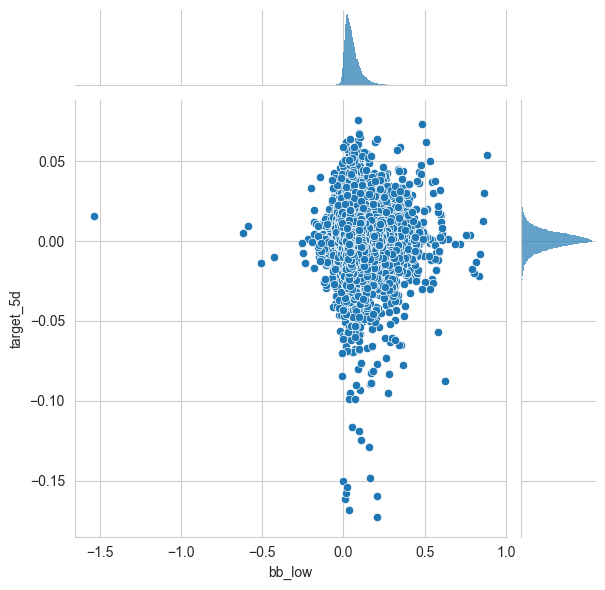

In [26]:
# Bollinger Bands  布林带
metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

4.10% (0.00%)


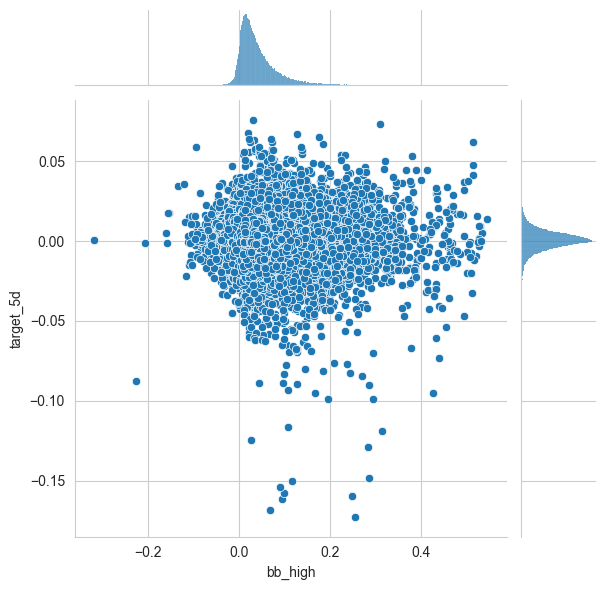

In [27]:
metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

-0.08% (77.56%)


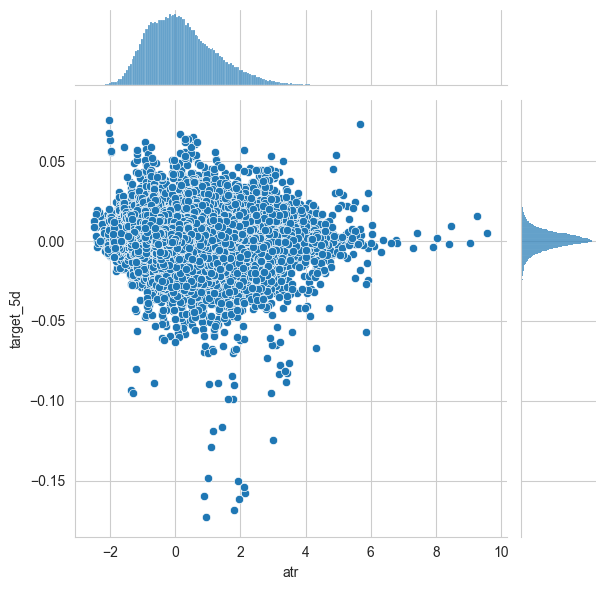

In [28]:
# ATR
metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

-5.02% (0.00%)


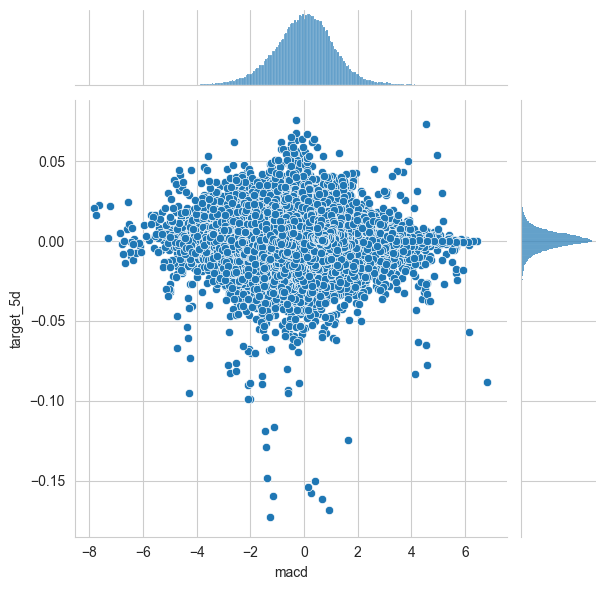

In [29]:
# MACD
metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')